# Data Scientist Challenge

In this coding challenge, you will analyze the real Blood Glucose variability and the iPhone-detected motion
activities of somobody. He's not a diabetic, but you never know. You will develop some Python functions and
modules, and some very basic statistical analysis. The main point of this challenge is to check your coding
skills, and how much you are at ease with performing some elementary statistical analysis.

## Input data

You have two files available:
* `blood-glucose.csv` is a CSV file with each line reporting a timestamp and a blood glucose level
(expressed in mg/dL), measured every 15 minutes. Please note that some values are missing.
* `motion.tsv` is a TSV file with each line reporting a timestamp and 5 boolean values. Each of these
boolean values refer to a type of activity, respectively 'stationary', 'walking', 'running', 'automotive' and
'cycling'. These must be interpreted in this way: when the user starts to walk, a line with 1 in the
walking position is reported; when the user stops walking, a line with 0 in that position is reported.
The whole period in between should be interpreted as walking. The same goes for the other activities.

Consider that it is possible to have multiple activities at the same time (for example, stationary and
automotive: think of being on a bus), and it's also possible to have no activities recognized at a given
time (meaning we don't know).

In [29]:
import pandas as pd
import numpy as np
import seaborn as sns
import datetime
import matplotlib.pyplot as plt
from ts_tools import get_ts_range, get_times_by_interval, get_floor_range, get_ceil_range
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.externals import joblib


In [2]:
blood_glucose = pd.read_csv('input/blood-glucose.csv', header=None, names=['times', 'blood_glucose'])
blood_glucose = blood_glucose[~ pd.isnull(blood_glucose['blood_glucose'])]
blood_glucose['times'] = blood_glucose['times'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S+00:00'))

In [3]:
blood_glucose.head()

,times,blood_glucose
42,2017-05-23 10:30:00,76.0
43,2017-05-23 10:45:00,73.0
44,2017-05-23 11:00:00,80.0
45,2017-05-23 11:15:00,92.0
46,2017-05-23 11:30:00,100.0


In [4]:
motion = pd.read_csv('input/motion.tsv', sep='\t', names=['times', 'stationary', 'walking', 'running', 'automotive', 'cycling'], header=None)
motion['times'] = motion['times'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%dT%H:%M:%S.%f+00:00'))

In [5]:
motion.tail()

,times,stationary,walking,running,automotive,cycling
13117,2017-06-02 23:52:16.418372,0,0,0,0,0
13118,2017-06-02 23:54:18.267440,1,0,0,0,0
13119,2017-06-02 23:54:21.136673,0,0,0,0,0
13120,2017-06-02 23:57:19.966934,0,1,0,0,0
13121,2017-06-02 23:57:25.666652,0,0,0,0,0


In [6]:
# Get time ranges of the whole data
init_dt = datetime.datetime(2017, 5, 23, 0, 0)
end_dt = datetime.datetime(2017, 6, 3, 0, 0)
time_ranges = get_ts_range(init_dt, end_dt, 900)

In [7]:
times = list(motion['times'])
times_intervals = np.zeros((len(time_ranges), 5))
col_activities = ['stationary', 'walking', 'running', 'automotive', 'cycling']

for i_col, col in enumerate(col_activities):
    idxs = np.where(np.diff(motion[col].as_matrix()) == -1)[0]
    # For each interval of activity
    for i in idxs:
        dt_ini = times[i]
        dt_end = times[i+1]
        # Fill times activity
        interval_ranges, times_intervals_range = get_times_by_interval(dt_ini, dt_end)
        
        i_init = time_ranges.index(interval_ranges[0])
        for i_i in range(len(times_intervals_range)):
            times_intervals[i_init + i_i, i_col] += times_intervals_range[i_i]


In [8]:
times_activities_48h = time_ranges[192:]
times_intervals_48h = np.zeros((len(times_intervals)-192, 5))
std_intervals_48h = np.zeros((len(times_intervals)-192, 5))

for i in range(len(times_intervals)-192):
    times_intervals_48h[i] = times_intervals[i:i+192].sum(0)
    std_intervals_48h[i] = times_intervals[i:i+192].std(0)


In [9]:
# Compute and interpolate blood glucose
init_time = get_floor_range(blood_glucose.times.iloc[0], 15)
endt_time = get_ceil_range(blood_glucose.times.iloc[-1], 15)
time_ranges_blood = get_ts_range(init_time, endt_time, 900)

blood_glucose_interp = np.zeros(len(time_ranges_blood))
blood_times = list(blood_glucose.times)
for i_time in range(len(blood_times)):
    try:
        idx = time_ranges_blood.index(blood_times[i_time])
        blood_glucose_interp[idx] = blood_glucose.blood_glucose.iloc[i_time]
    except:
        pass

idxs = np.where(blood_glucose_interp)[0]
# TOImprove: better interpolation
blood_glucose_interp = np.interp(range(len(blood_glucose_interp)), idxs, blood_glucose_interp[idxs])


In [10]:
# Compute the std of the blood glucose level on the last 48h
blood_glucose_std_48h = np.zeros(len(blood_glucose_interp)-192)
for i in range(len(blood_glucose_interp)-192):
    blood_glucose_std_48h[i] = blood_glucose_interp[i:i+192].std(0)
time_ranges_blood_48h = time_ranges_blood[192:]

In [11]:
# Compute std blood glucose
walking_time_48h = np.zeros(len(time_ranges_blood_48h))
for i_time in range(len(times_intervals_48h)):
    try:
        idx = time_ranges_blood_48h.index(times_48h[i_time])
        walking_time_48h[idx] = times_intervals_48h[i_time, 1]
    except:
        pass
    
times_48h = time_ranges_blood_48h


In [25]:
walking_time_at_interval = np.zeros(len(times_48h))
for i_time in range(len(walking_time_at_interval)):
    try:
        idx = times_48h.index(time_ranges[i_time])
        walking_time_at_interval[idx] = times_intervals[i_time, 1]
    except:
        pass

### Plots of computed values

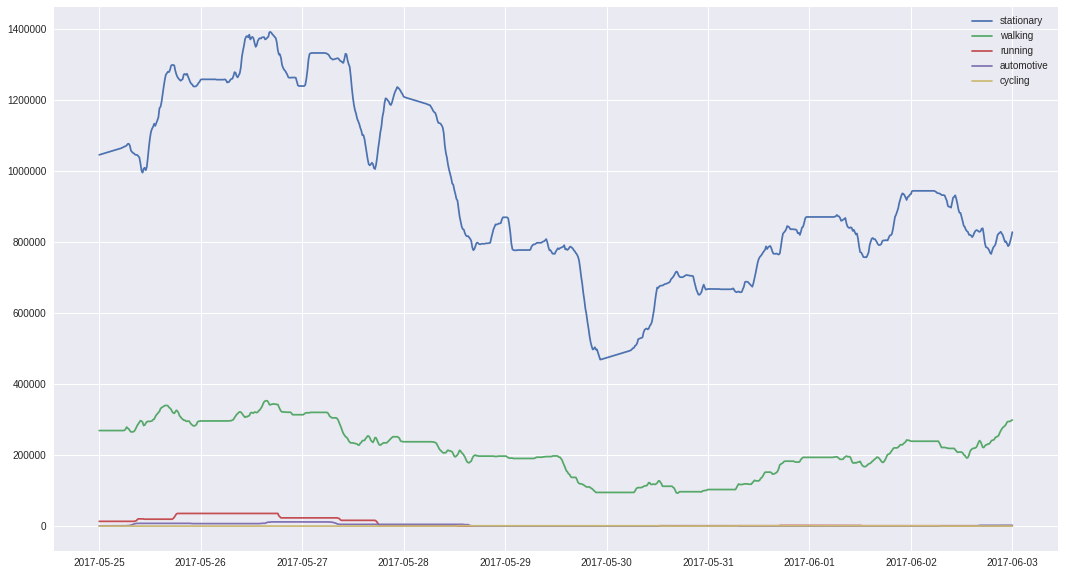

In [12]:
## Plot
fig, ax = plt.subplots(figsize=(18, 10))

for i_col in range(5):
    plt.plot(times_activities_48h, times_intervals_48h[:, i_col], label=col_activities[i_col])

_ = plt.legend()


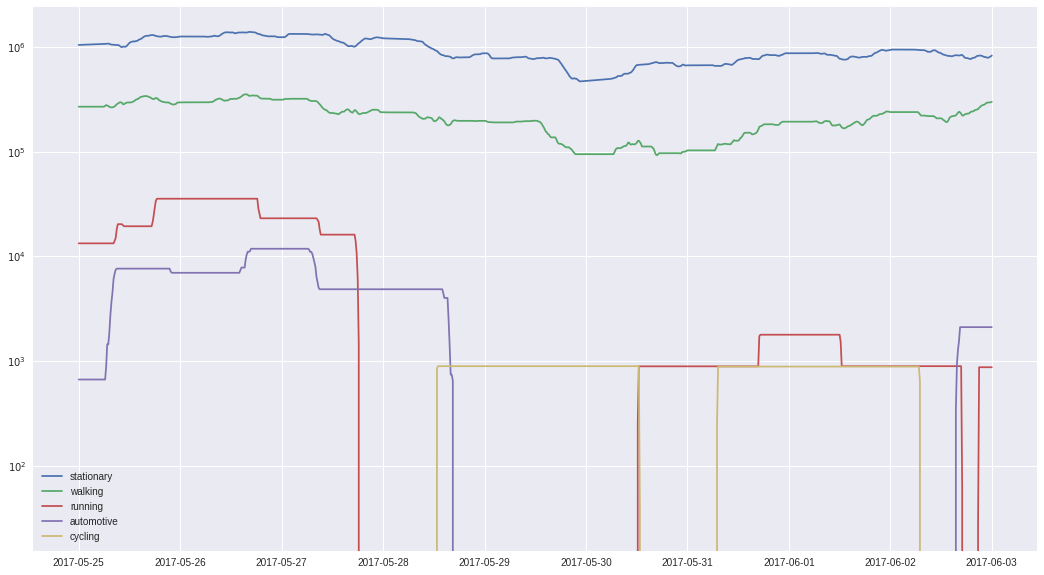

In [13]:
## Plot
fig, ax = plt.subplots(figsize=(18, 10))

for i_col in range(5):
    plt.plot(times_activities_48h, times_intervals_48h[:, i_col], label=col_activities[i_col])

ax.set_yscale('log')
_ = plt.legend()

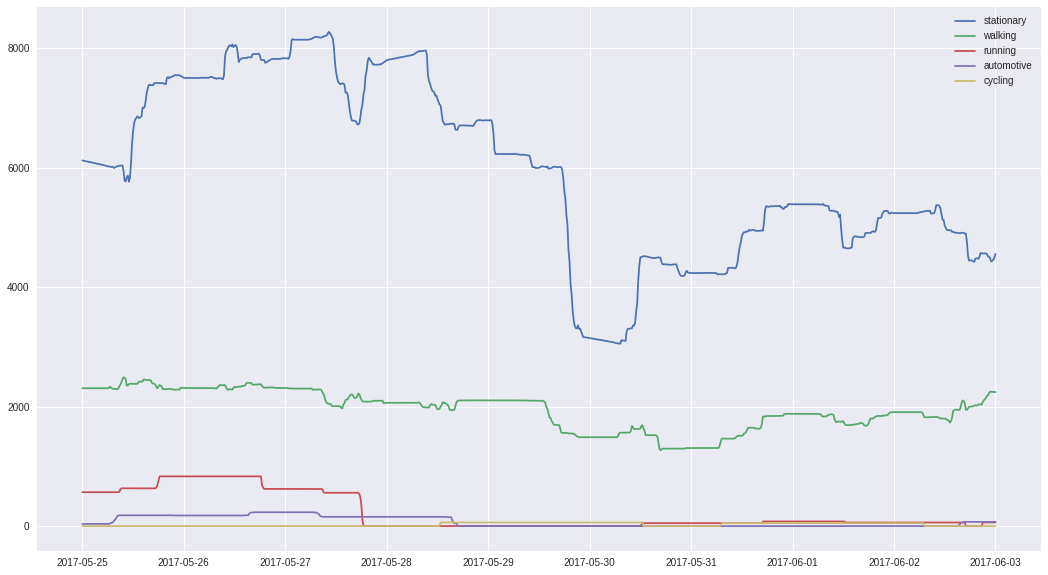

In [14]:
## Plot
fig, ax = plt.subplots(figsize=(18, 10))

for i_col in range(5):
    plt.plot(times_activities_48h, std_intervals_48h[:, i_col], label=col_activities[i_col])

_ = plt.legend()

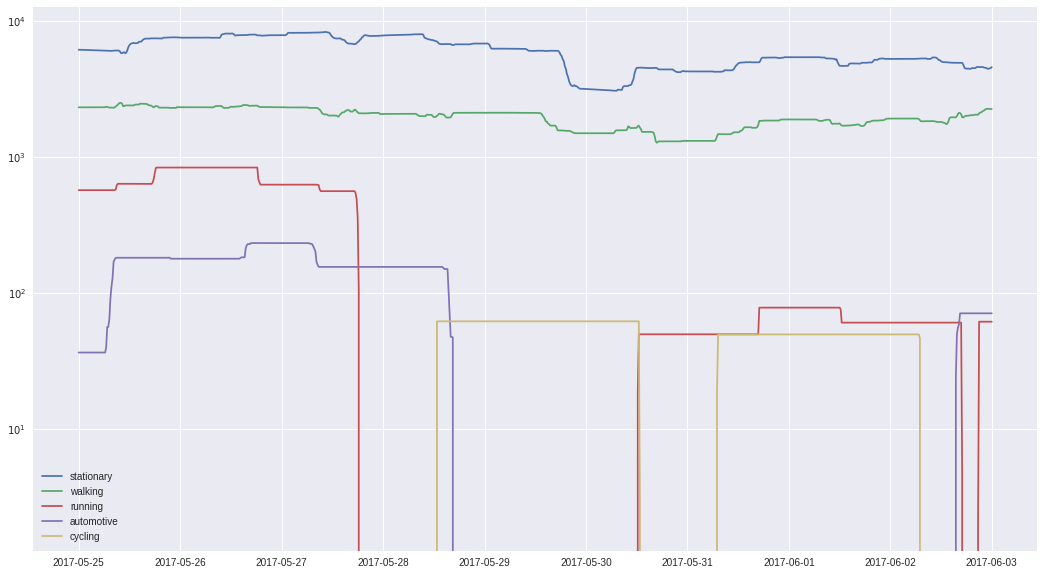

In [15]:
## Plot
fig, ax = plt.subplots(figsize=(18, 10))

for i_col in range(5):
    plt.plot(times_activities_48h, std_intervals_48h[:, i_col], label=col_activities[i_col])

ax.set_yscale('log')
_ = plt.legend()

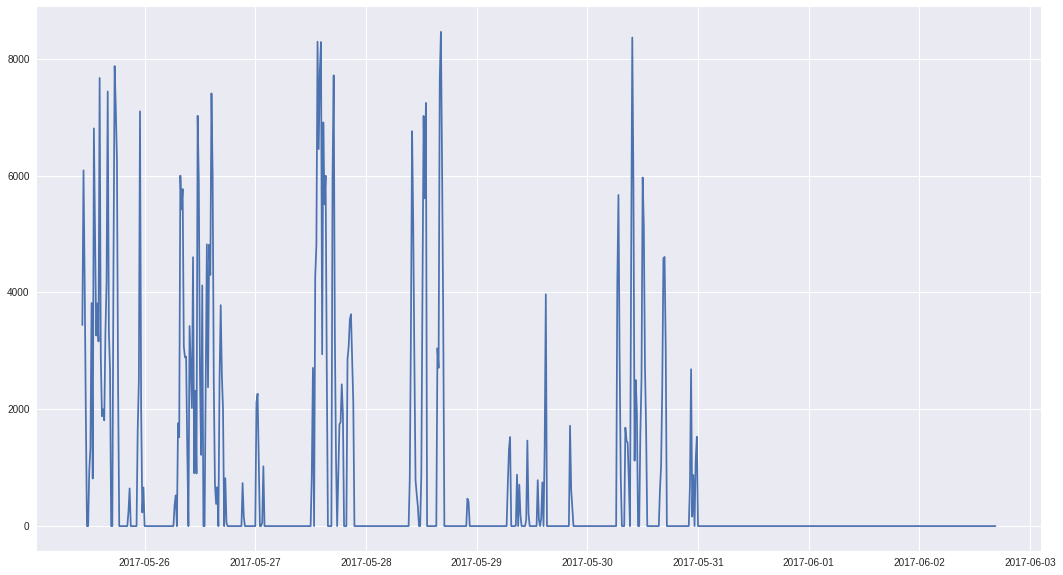

In [26]:
## Plot
fig, ax = plt.subplots(figsize=(18, 10))

_ = plt.plot(times_48h, walking_time_at_interval)


### Correlation

In [16]:
np.correlate(walking_time_48h, blood_glucose_std_48h)[0]

2055757109.7551129

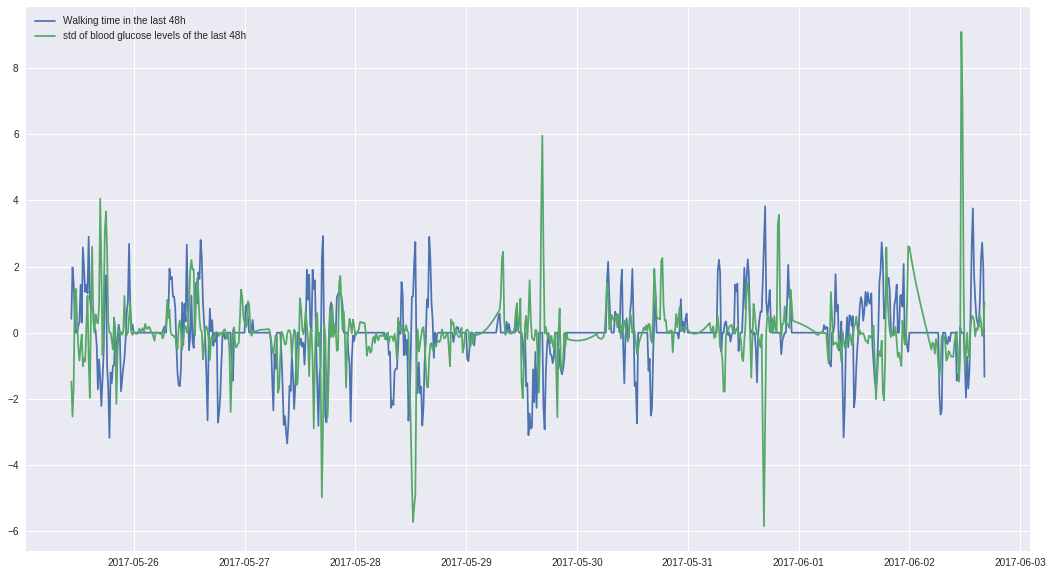

In [17]:
## Plot
fig, ax = plt.subplots(figsize=(18, 10))


diff_walking = np.diff(walking_time_48h)
diff_blood_glucose = np.diff(blood_glucose_std_48h)

plt.plot(times_48h[:-1], diff_walking/np.std(diff_walking), label="Walking time in the last 48h")
plt.plot(times_48h[:-1], diff_blood_glucose/np.std(diff_blood_glucose), label="std of blood glucose levels of the last 48h")

_ = plt.legend()

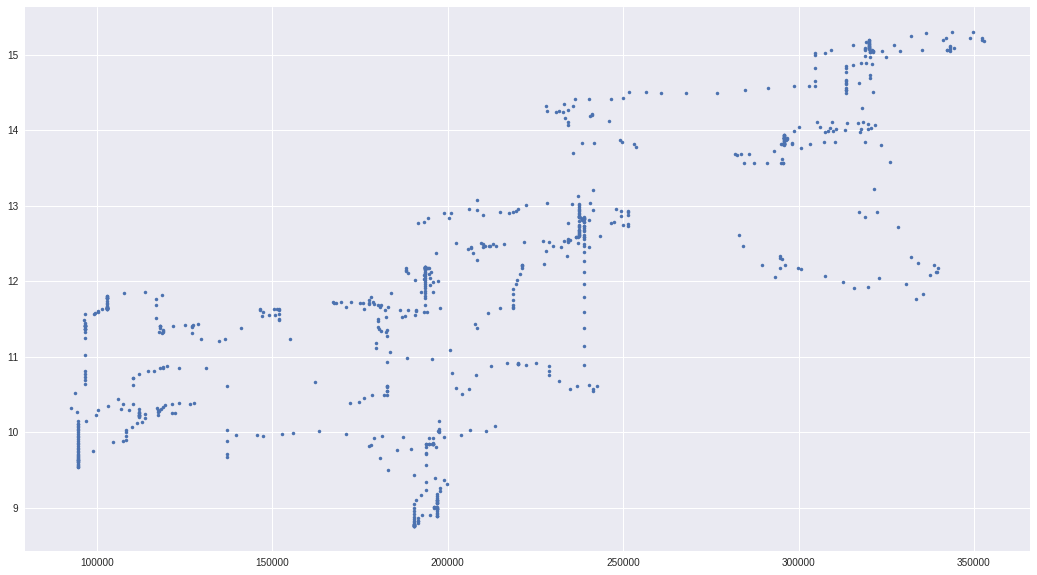

In [18]:
## Plot
fig, ax = plt.subplots(figsize=(18, 10))

_ = plt.plot(walking_time_48h, blood_glucose_std_48h, '.')


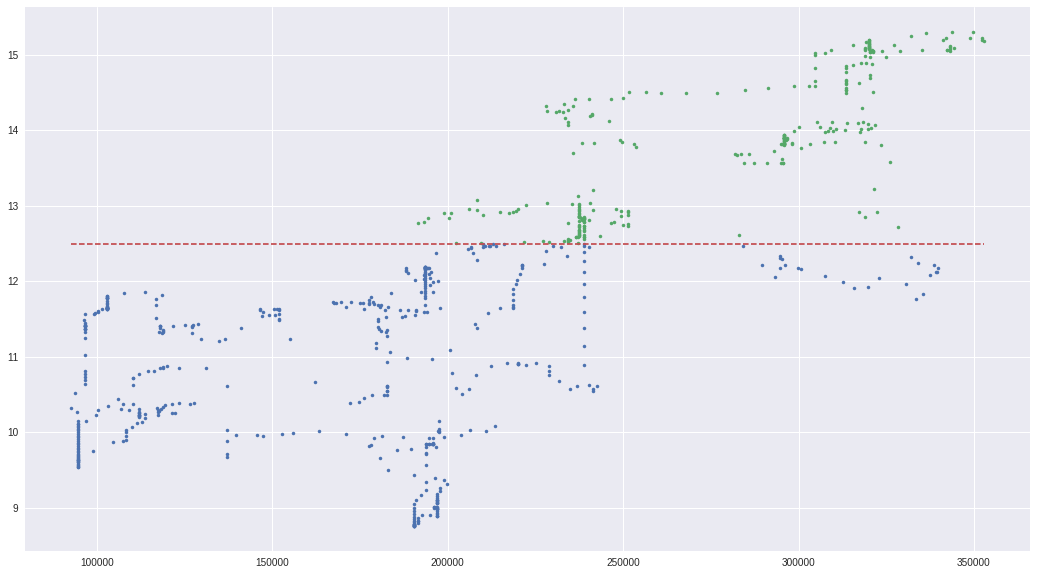

In [19]:
## Plot
fig, ax = plt.subplots(figsize=(18, 10))

over_logi = blood_glucose_std_48h > 12.5
under_logi = np.logical_not(over_logi)

_ = plt.plot(walking_time_48h[under_logi], blood_glucose_std_48h[under_logi], '.')
_ = plt.plot(walking_time_48h[over_logi], blood_glucose_std_48h[over_logi], '.')

_ = plt.plot(np.linspace(walking_time_48h.min(), walking_time_48h.max(), 100), 12.5*np.ones(100), linestyle='dashed')



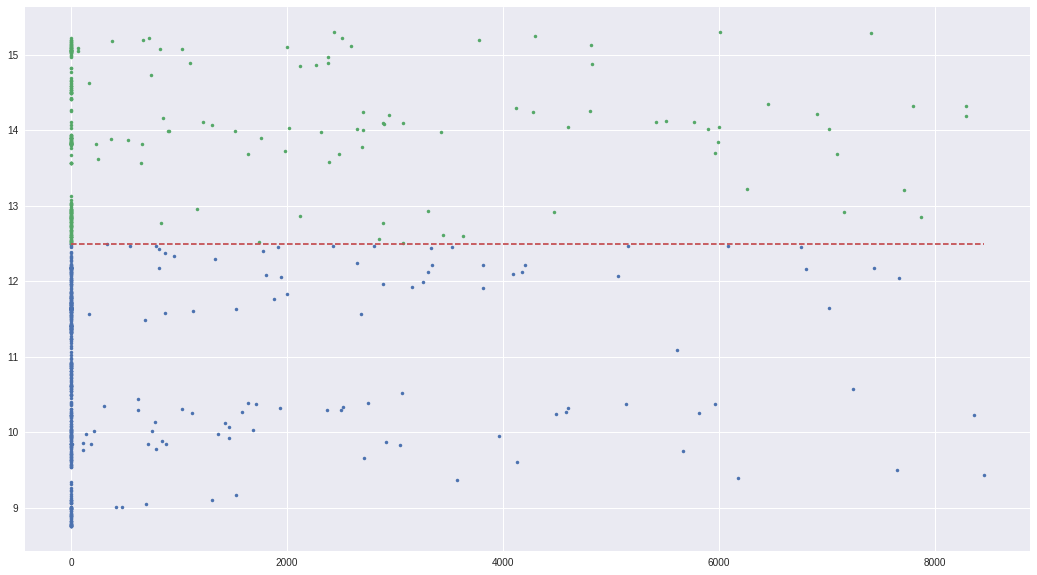

In [27]:
## Plot of correlation of walking in that time
fig, ax = plt.subplots(figsize=(18, 10))

walking_time_at_interval

over_logi = blood_glucose_std_48h > 12.5
under_logi = np.logical_not(over_logi)

_ = plt.plot(walking_time_at_interval[under_logi], blood_glucose_std_48h[under_logi], '.')
_ = plt.plot(walking_time_at_interval[over_logi], blood_glucose_std_48h[over_logi], '.')

_ = plt.plot(np.linspace(walking_time_at_interval.min(), walking_time_at_interval.max(), 100), 12.5*np.ones(100), linestyle='dashed')


### Prediction

In [40]:
## Dummy model
model = LogisticRegression(penalty='l2', dual=False, tol=0.0001, C=1.0, fit_intercept=True)
param_grid = { 
    'penalty': ['l2'],
    'C': [0.1, 1., 10.]
}

CV_model = GridSearchCV(estimator=model, param_grid=param_grid, cv=5)
CV_model.fit(walking_time_48h.reshape(-1, 1), blood_glucose_std_48h>14.5)


GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'penalty': ['l2'], 'C': [0.1, 1.0, 10.0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [41]:
CV_model.best_score_

0.89281210592686

In [42]:
CV_model.predict_proba([[100000]])

array([[ 0.6748908,  0.3251092]])

In [43]:
CV_model.predict_proba([[350000]])

array([[ 0.92799991,  0.07200009]])

In [44]:
## Store trained model
joblib.dump(CV_model, 'model_blood_glucose.pkl')


['model_blood_glucose.pkl']

In [50]:
### Prediction using walking times in each moment
# Dummy model
model = LogisticRegression(penalty='l2', dual=False, tol=0.0001, C=1.0, fit_intercept=True)
param_grid = { 
    'penalty': ['l2'],
    'C': [0.1, 1., 10.]
}

CV_model = GridSearchCV(estimator=model, param_grid=param_grid, cv=5)
CV_model.fit(walking_time_at_interval.reshape(-1, 1), blood_glucose_std_48h>14.5)


GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'penalty': ['l2'], 'C': [0.1, 1.0, 10.0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [51]:
CV_model.best_score_

0.89281210592686

In [52]:
CV_model.predict_proba([[8000]])

array([[ 0.91783258,  0.08216742]])

In [53]:
CV_model.predict_proba([[0]])

array([[ 0.86444132,  0.13555868]])

In [54]:
## Store trained model
joblib.dump(CV_model, 'model_interval_blood_glucose.pkl') 

['model_interval_blood_glucose.pkl']